<p>
    <img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;">
    <h1 style="color:#1A5276;padding-left:115px;padding-bottom:0px;font-size:28px;">AWS IoT Analytics | Predictive Maintenance of Jet Engines </h1>
</p>
<p style="color:#1A5276;padding-left:90px;padding-top:0px;position:relative;font-style:italic;font-size:18px">
A multivariate LSTM Neural Network and Logistic Regression prediction of remaining useful lifetime of engines.</p>

Predicting failure is a classic request of IoT systems. By predicting which devices will fail, proactive maintenance can be scheduled to increase device uptime, optimize asset utilization, avoid costly catastrophic device failure and optimize field service efficiency. In this Notebook template, we will show how to implement a multi-series, multivariate binary classification algorithm to predict which jet engines will fail within a given time threshold based on turbofan measurements. This Notebook template can be explored as-is for educational purposes, or repurposed to fit your data and deliver immediate value.

## Set-up: Import Required Notebook Libraries

<p>This Notebook requires a few basic Python libraries including <a href="http://pandas.pydata.org/">`pandas`</a>, <a href="http://www.numpy.org/">`numpy`</a>, <a href="https://keras.io/">`keras`</a>, <a href="https://www.tensorflow.org/">`tensorflow`</a> and <a href="https://matplotlib.org/">`matplotlib`</a>.</p>

In [1]:
import warnings

warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from __future__ import unicode_literals, division

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import boto3
import os
import sys

import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.wrappers.scikit_learn import KerasClassifier

from scipy.stats import norm
from scipy.stats import norm
import matplotlib.mlab as mlab

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (17, 10)

Using TensorFlow backend.


In [3]:
try:
    import sklearn
except ImportError:
    !conda install -c conda-forge --yes --prefix {sys.prefix} scikit-learn
    
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn import linear_model

## Background: Problem Description and Approach

In order to support business decision making, we must be able to take action on predictive analytics. For predictive failure analysis, this means we want to know which devices will fail and when. Given that different operational and business processes, such as initiating a maintenance request or moving replacement inventory, have different timescales, it is often helpful to be able to categorize device failures by time-to-failure or remaining useful life. To solve this for a complex device that has multiple operation modes and reports time-series measurements from multiple sensors, our primary approach is an <a href="https://www.tensorflow.org/tutorials/recurrent">LSTM</a> neural network in TensorFlow. This provides multivariate binary classification to predict whether an engine will fail (yes or no) within the specified time window. 

<img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;height:20px;"></img><b style="color:#1A5276;padding-left:5px;">BEST PRACTICES NOTE</b> Different modelling approaches provide different business trade-offs, and different teams may opt for different approaches. For example, although the field service team is interested in the most precise prediction for any given engine in order to eliminate false positives and unnecessary truck rolls, sales is interested in all possible devices that could fail in order to target their marketing at a broader pool of customers. To compare trade-offs, we have included an initial approach using the statistical method of Logistic Regression for the binary classification.

<h1 style="color:#20B3CD;font-size:20px;float:left">Step 1  |  Loading Data </h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

### Data Set Description

For simple devices with few failure modes, anomaly detection techniques can often be employed that detect patterns of increased instability which precede and indicate failure. In this Notebook template, we are concerned with more complex devices that have multiple operational modes, runtime sensor measurements and multi-modal failure patterns. The sample data is simulated <a href="https://www.grc.nasa.gov/www/k-12/airplane/Animation/turbtyp/etft.html">turbofan jet engine</a> data from NASA's Ames Research Center. The data set represents 100 turbofan engines and simulates the noisiness of physically measured data, manufacturing defects, and wear and tear.   

NASA's sample data actually contains 3 data sets. Here we use FD001 which consists of 21 turbofan sensor measurements, 3 operational settings variables and the time period measured in duty cycles. There are 20631 observations across all 100 units. Based on the sensor data, we would like to predict whether the engine will fail within the next 30 days.

<p style="font-weight:bold">Data Set Attribution:</p> A. Saxena and K. Goebel (2008). ���Turbofan Engine Degradation Simulation Data Set���, NASA Ames Prognostics Data Repository, NASA Ames Research Center, Moffett Field, CA

The data can be downloaded from this page: https://ti.arc.nasa.gov/c/6/

In [4]:
# describe the data set structure for import
descriptive_columns = ['id', 'cycle']
operational_columns = ['setting1', 'setting2', 'setting3']
observational_columns = ['s1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
all_columns = descriptive_columns + operational_columns + observational_columns

The sample data has already been separated into training, test and truth data sets. In the training data, we get each engine until failure. In the test data, we get each engine up to a point in time, but not until failure. The final data set, the truth data set, tells us when each engine in the test set fails.

<img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;height:20px;"></img><b style="color:#1A5276;padding-left:5px;">PRODUCTION NOTE</b> The training data is structured for time-to-target analysis where training includes the precursor and target event (jet engine failure in our case). The testing data is the data preceding the event and truth represents the event itself to confirm testing results. To use this template as-is, you'll want to structure your training, testing and truth data similarly.

Before actually loading the data we need to set up an IoT Analytics client for accessing datasets.

In [5]:
import boto3

# create IoT Analytics client
client = boto3.client('iotanalytics')

In order to run the algorithm on your data, set the use_sample_dataset variable below to False. In order to need to perform get_dataset_content, you need to grant iot analytics corresponding IAM permission.

In [6]:
use_sample_dataset = True
dataset = "all_data"

Now we load data either from the IoT Analytics dataset specified in the dataset variable or the sample traffic sensor dataset (if use_sample_dataset is True or the specified IoT Analytics dataset is invalid).

In [7]:
try: # read dataset contents into a data frame
    if use_sample_dataset:
        raise Exception('Using sample data since use_sample_dataset is True')
    dataset_url = client.get_dataset_content(datasetName = dataset)['entries'][0]['dataURI']
    train = pd.read_csv(dataset_url)
    if train.empty:
        raise Exception('No data found')
except: # use sample dataset in case of any error
    train = pd.read_csv('https://s3.amazonaws.com/iotanalytics-templates/data/turbofan-engine/train_FD001.txt', sep=' ', header=None) # reads the csv into a Pandas DataFrame
    train.drop(train.columns[[26, 27]], axis=1, inplace=True) # removes unnecessary columns
    from IPython.display import display, Markdown
    import traceback
    display(Markdown('# <span style="color:black">{}</span>\n{}'.format('Using the sample dataset', traceback.format_exc())))

train.columns = all_columns 
train.head() # displays the first entries of the DataFrame

# <span style="color:black">Using the sample dataset</span>
Traceback (most recent call last):
  File "<ipython-input-7-5b6b1505c070>", line 3, in <module>
    raise Exception('Using sample data since use_sample_dataset is True')
Exception: Using sample data since use_sample_dataset is True


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:11: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


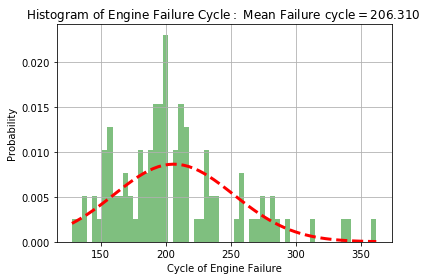

In [8]:
#histogram of the cycle at which the engines fail 
max_cyc = train.groupby(['id'], sort=False)['cycle'].max()

# fit linear regression to estimate density
(mu, sigma) = norm.fit(max_cyc.as_matrix())

# make historgram
n, bins, patches = plt.hist(max_cyc.as_matrix(), 60, density=1, facecolor='green', alpha=0.5)

# add normal density line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=3)

#plot
plt.xlabel('Cycle of Engine Failure')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ Engine\ Failure\ Cycle:\ Mean\ Failure\ cycle=}%.3f$ ' %(mu))
plt.grid(True)

plt.show()

  We see that engines fail around cycle 206, on average.  Some engines failed as early as cycle 128, while others lasted until cycle 362. 

We download test and truth data from the sample dataset, however you can copy the IoT Analytics dataset access code from above to fetch data from your dataset.

In [9]:
# import test data
test = pd.read_csv('https://s3.amazonaws.com/iotanalytics-templates/data/turbofan-engine/test_FD001.txt', sep=" ", header=None)
test.drop(test.columns[[26, 27]], axis=1, inplace=True)
test.columns = all_columns

In [10]:
# import truth data
truth = pd.read_csv('https://s3.amazonaws.com/iotanalytics-templates/data/turbofan-engine/RUL_FD001.txt', sep=" ", header=None)
truth.drop(truth.columns[[1]], axis=1, inplace=True)

<h1 style="color:#20B3CD;font-size:20px;float:left">Step 2  |  Processing Data</h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

### Target Parameter Determination

In order to model a binary classification, we need a target parameter that puts all the data on the same basis for supervised training and the subsequent classification test. For failure analysis, we will assume attribute data that happened within 30 days of failure are associated with that failure.  

To mark these observations as 'failure', we first need to define the RUL (remaining useful life) variable.  This is defined as the duty cycles remaining until the engine fails or the lifetime left in the engine. Our sample data includes the duty cycle number, i.e. the number of operational cycles that an engine has gone through at the time of the sensor measurements but does not include the RUL. So we'll have to calculate it and add it to the dataFrame. 

For a given engine, RUL = cycle at failure (max) - current cycle (cycle).  Engine failure is defined as RUL <= DAYS_IN_ADVANCE.  Note that the DAYS_IN_ADVANCE parameter can be modified to predict failure within any time window.  For example, setting DAYS_IN_ADVANCE=60 would model device failure within 60 days. 

As part of our data preperation, we'll need two variables:
<div><b style="margin-left:50px;font-style:italic;font-size:12px;">LOOKBACK_LENGTH</b> - number of cycles in the past we'll use to predict whether the engine will fail</div> 
<div><b style="margin-left:50px;font-style:italic;font-size:12px">DAYS_IN_ADVANCE</b> - number of cycles ahead that we're trying to predict whether the engine will fail</div>

In [11]:
LOOKBACK_LENGTH = 10
DAYS_IN_ADVANCE = 30

In [12]:
# find the max number of cycles for each engine before failure and add it as a column into our training data
rul = pd.DataFrame(train.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train = train.merge(rul, on=['id'], how='left')

#calculate RUL (the maximum cycle before the engine failed minus the current cycle) and add it 
#as a column in the Training data after which we can remove the column we added for the max cycle 
train['RUL'] = train['max'] - train['cycle']
train.drop('max', axis=1, inplace=True)

### Sensor Measurement Normalization

Multivariate problems require normalization of sensor measurements and operational settings to remove the effects of different scales being used across the units of measure, for example, air speed (Mach) versus inlet pressure (kPa). The 'MinMaxScaler' transforms each value into a given range, in our case between 0 and 1.

Below is the transformation we are performing on each sensor measurement. <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html">CLICK</a> to learn more.
<div style="margin-left:50px;margin-top:15px">X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))</div>
<div style="margin-left:50px;">X_scaled = X_std * (max - min) + min</div>

In [13]:
#specify the dataFrame columns to normalize, all sensor and settings columns
train['cycle_norm'] = train['cycle']
cols_normalize = train.columns.difference(['id','cycle','RUL'])

#apply normalization and add back in the columns for 'id', 'cycle' and 'RUL' that we didn't transform
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train[cols_normalize]),  columns=cols_normalize, index=train.index)
join_df = train[train.columns.difference(cols_normalize)].join(norm_train_df)
train = join_df.reindex(columns = train.columns)

### Repeat Data Processing For Test Data Sets

Testing data requires the same normalization steps as training data. We'll again calculate the RUL and normalize the sensor measurements and operational settings with the MinMaxScaler. 

In [14]:
# generate column max for test data
rul = pd.DataFrame(test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth.columns = ['more']
truth['id'] = truth.index + 1
truth['max'] = rul['max'] + truth['more']
truth.drop('more', axis=1, inplace=True)

In [15]:
# generate RUL for test data
test = test.merge(truth, on=['id'], how='left')
test['RUL'] = test['max'] - test['cycle']
test.drop('max', axis=1, inplace=True)
# test.head()

In [16]:
# normalize test data with MinMax normalization in the training data section

test['cycle_norm'] = test['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test.index)
test_join_df = test[test.columns.difference(cols_normalize)].join(norm_test_df)
test = test_join_df.reindex(columns = test.columns)
test = test.reset_index(drop=True)
# test.head()

In [17]:
train['Y'] = np.where(train['RUL'] <= DAYS_IN_ADVANCE, 1, 0)
test['Y'] = np.where(test['RUL'] <= DAYS_IN_ADVANCE, 1, 0)

In [18]:
feature_columns = operational_columns + ['cycle_norm'] + observational_columns

<h1 style="color:#20B3CD;font-size:20px;float:left">Step 3  |  Train & Test Your Model</h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

As mentioned in the Best Practices Note at the beginning of this Notebook, different modeling approaches can prove useful for answering various questions from different business and operational teams. To illustrate this, we are comparing Logistic Regression to an LSTM Neural Network approach to predicting the remaining useful lifetime in cycles of the engines and to classify the fleet of engines based on those that will fail within a specified time window (DAYS_IN_ADVANCE).

### Approach 1  | Binary Classification via Logistic Regression

In [19]:
#structure the training data DataFrame for prediction
train_Y = train['Y']
train_rolling = train.groupby('id').rolling(LOOKBACK_LENGTH, min_periods=1).mean()
train_rolling = train_rolling.reset_index(0, drop=True).drop('cycle', axis=1)
train_rolling["Y"] = train_Y 

#define variable to predict, Remaining Useful Life
X = train_rolling.drop(['Y','RUL'], axis=1)
Y = train_rolling['Y'].astype('int')

#fit the model with training data set
logreg = linear_model.LogisticRegression(C=1e5)
lr_model = logreg.fit(X, Y)

Now that we've fit the Logistic Regression model to the training data, we can use the trained model on the test data to see how it performs. To measure the performance of the model, we generate the confusion or error matrix and calculate the Accuracy, Precision and Hit Rate for the model. 

In [20]:
#structure the testing data DataFrame for prediction
test_y = test["Y"]
all_test = test.groupby('id').rolling(LOOKBACK_LENGTH, min_periods=1).mean()
all_test = all_test.reset_index(0, drop=True).drop('cycle', axis=1)
all_test["Y"] = test_y

#define features and variable to predict Remaining Useful Life
X_test_lr = all_test.drop(['Y','RUL'] ,axis=1)
Y_test_lr = all_test['Y'].astype('int')

#run the trained logistic regression model on the test data 
preds = lr_model.predict(X_test_lr)

#calculate model performance - accuracy, precision and hit rate or recall
logistic_acc = accuracy_score(Y_test_lr, preds)
logistic_prec = precision_score(Y_test_lr, preds)
logistic_recall = recall_score(Y_test_lr, preds)

print('---  Confusion Matrix  ---\n(x-axis are true labels, y-axis are predicted labels)')
cm = confusion_matrix(Y_test_lr, preds)
print(cm)
print('\nAccurracy:\t{}'.format(logistic_acc))
print("Precision:\t{}".format(logistic_prec))
print("Hit Rate:\t{}".format(logistic_recall))

---  Confusion Matrix  ---
(x-axis are true labels, y-axis are predicted labels)
[[12703    61]
 [  127   205]]

Accurracy:	0.98564447159438
Precision:	0.7706766917293233
Hit Rate:	0.6174698795180723


<img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;height:20px;"></img><b style="color:#1A5276;padding-left:5px;">HUMAN LEARNING NOTE</b> A confusion matrix is a 2x2 matrix used to describe the outcomes of classification models. In our formatting, the upper left quadrant is the True Positive results where the model correctly identified the engine failure within the DAYS_IN_ADVANCE period and the upper right is the False Positive results. The bottom left quadrant is the False Negative results where the model predicted failure incorrectly and the bottom right quadrant is the True Negatives where the model correctly predicted an engine wouldn't fail. <a href="https://en.m.wikipedia.org/wiki/Confusion_matrix">CLICK</a> to learn more about confusion matrices and precision, accuracy and hit rate calculations.

### Approach 2  | Binary Classification via LSTM

Before we examine the results of the Logistic Regression model, let's try our second approach, LSTM. LSTM or 'Long Short-Term Memory' is a recurrent neural network that is particularly forgiving of unknown time gaps between significant events in time-series, such as the unknown time gap to failure, and is capable of handling large data sets. This makes it very useful for prediction with IoT data. 

First we need to get our data into a format that Keras LSTM accepts. Keras LSTM layers expect an input in the following shape: (batch_size, timesteps, input_dim)
<div><b style="margin-left:50px;font-style:italic;font-size:13px;">batch_size</b> - number of sequences</div>
<div><b style="margin-left:50px;font-style:italic;font-size:13px;">timesteps</b> - the sequence length to look back, look back cycles in our example</div>
<div><b style="margin-left:50px;font-style:italic;font-size:13px;">input_dim</b> - number of features of each sequence at each time step</div>

<img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;height:20px;"></img><b style="color:#1A5276;padding-left:5px;">HUMAN LEARNING NOTE</b> Keras is a neural network (NN) framework that makes running NN fast and easy on TensorFlow, used here, as well as Theano and CNTK.

In [21]:
#set the pseudo-random number generator seed to ensure the same layer evolution with each run
seed = 7
np.random.seed(seed)

#### Data Structuring for LSTM
LSTM and other neural networks require specific data structuring in order to construct the network layers and backpropagation for training. Below we are converting a pandas DataFrame to 2 numpy arrays to train our Keras LSTM model. The X_train array carries the normalized sensor and settings data, i.e the training data and the y_train array holds the target (label) data.

In [22]:
#iterate over the training data to seperate out the arrays for each neural network layer 
def flip_data(df, lookback_length, feature_columns):
    Y_train = []
    X_train = []
    for i in df['id'].unique():
        if i % 10 ==0 or i == 1:
            print("Starting cycle: " + str(i))
        temp_df = df[df['id'] == i]
        data_array = temp_df[feature_columns].values
        num_elements = data_array.shape[0]

        for cycle in temp_df['cycle'].unique():
            if cycle - lookback_length > 1:
                a = temp_df[temp_df['cycle'] == cycle]['Y'].values[0]
                Y_train.append(a)

                start = cycle - lookback_length
                this_data = data_array[start:cycle,:]
                X_train.append(this_data)

    return np.rollaxis(np.dstack(X_train),-1), np.array(Y_train)

In [23]:
X_train, Y_train = flip_data(train, LOOKBACK_LENGTH, feature_columns)

Starting cycle: 1
Starting cycle: 10
Starting cycle: 20
Starting cycle: 30
Starting cycle: 40
Starting cycle: 50
Starting cycle: 60
Starting cycle: 70
Starting cycle: 80
Starting cycle: 90
Starting cycle: 100


#### LSTM Model Set-up and Training
Now that we have the data structured for training, we can set the parameters in our LSTM model. Here we are using a sequential LSTM model for binary classification. This model configuration choice makes our model capable of learning higher level temporal representations, such as we have with our target parameter Remaining Useful Life, in the engine case. 



In [24]:
#define the feature count from the X numpy array containing   
feature_count = X_train.shape[2]

#set LSTM model characteristics with training data parameters, note we have chosen to train with 100 true events and 
model = Sequential()
model.add(LSTM(
         input_shape=(LOOKBACK_LENGTH, feature_count),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

#display LSTM model training characteristics
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 100)           50400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


As LSTM is a recurrent neural network, we can observe the incremental training at each iteration or epoch on the training data set. The below printout summarizes the accuracy or the percent of correctly classified 

<img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;height:20px;"></img><b style="color:#1A5276;padding-left:5px;">PRODUCTION NOTE</b> we have chosen to train over 10 epochs. This allows us to test the model within a reasonable timeframe. Notice that the loss is continuing to decrease which suggests that additional epochs would continue to improve the model without overfitting.

In [25]:
# train the LSTM network with our training data
history = model.fit(X_train, Y_train, epochs=25, batch_size=200, validation_split=0.05, verbose=2)

Train on 18554 samples, validate on 977 samples
Epoch 1/25
 - 22s - loss: 0.1821 - acc: 0.9240 - val_loss: 0.1570 - val_acc: 0.9386
Epoch 2/25
 - 17s - loss: 0.1244 - acc: 0.9492 - val_loss: 0.1057 - val_acc: 0.9458
Epoch 3/25
 - 17s - loss: 0.1169 - acc: 0.9506 - val_loss: 0.1516 - val_acc: 0.9417
Epoch 4/25
 - 20s - loss: 0.1082 - acc: 0.9534 - val_loss: 0.0908 - val_acc: 0.9570
Epoch 5/25
 - 19s - loss: 0.1029 - acc: 0.9587 - val_loss: 0.1427 - val_acc: 0.9417
Epoch 6/25
 - 21s - loss: 0.0993 - acc: 0.9593 - val_loss: 0.0948 - val_acc: 0.9560
Epoch 7/25
 - 20s - loss: 0.0953 - acc: 0.9601 - val_loss: 0.0939 - val_acc: 0.9580
Epoch 8/25
 - 14s - loss: 0.0920 - acc: 0.9632 - val_loss: 0.1242 - val_acc: 0.9498
Epoch 9/25
 - 15s - loss: 0.0923 - acc: 0.9607 - val_loss: 0.0969 - val_acc: 0.9550
Epoch 10/25
 - 14s - loss: 0.0896 - acc: 0.9623 - val_loss: 0.0921 - val_acc: 0.9601
Epoch 11/25
 - 14s - loss: 0.0896 - acc: 0.9624 - val_loss: 0.1129 - val_acc: 0.9560
Epoch 12/25
 - 8s - loss: 

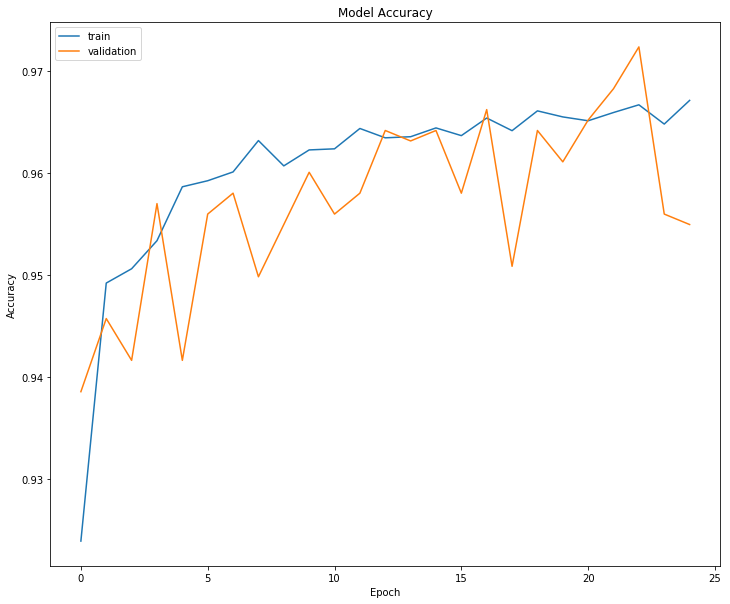

In [26]:
# plot accuracy as we learn
fig_acc = plt.figure(figsize=(12, 10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# fig_acc.savefig("../../Output/model_r2.png")

The above graph demonstrates the accuracy the model is achieving as it is being trained. When we created the model, we used a validation_split of .05. This means that 5% of the training data is held out of the training every epoch. At the end of each epoch, the model evaluates the accuracy of both the training data and the validation data. 

Typically, the validation accuracy will be lower than the training accuracy because the model has not seen these data points before.

Given that both the training and validation accuracy still seem to be rising, we can conclude that the model would benefit from more training which we could do by adding more epochs.

In [27]:
#calculate the final loss scores and accuracy of the trained model 
scores = model.evaluate(X_train, Y_train, verbose=1, batch_size=200)

#printed below is correct classifications/total classifications of the trained model

19531/19531 [==============================] - 3s 138us/step


In [28]:
# make predictions on, compute confusion matrix, calculate accuracies
y_pred = model.predict_classes(X_train,verbose=0, batch_size=200)
y_true = Y_train

print("Training Data Statistics\n")
print('---Confusion matrix---\n(x-axis are true labels, y-axis are predicted labels)')
cm = confusion_matrix(y_true, y_pred)
print(cm)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
# auc = auc(y_true, y_pred)
print('\nAccurracy:\t{}'.format(scores[1]))
print("Precision:\t{}".format(precision))
print("Recall:\t\t{}".format(recall))
# print(auc)

Training Data Statistics

---Confusion matrix---
(x-axis are true labels, y-axis are predicted labels)
[[16308   123]
 [  547  2553]]

Accurracy:	0.965695564772858
Precision:	0.9540358744394619
Recall:		0.8235483870967742


### Apply Model to Test Data

In [29]:
X_test, Y_test = flip_data(test, LOOKBACK_LENGTH, feature_columns)
print(X_test.shape)
print(Y_test.shape)

Starting cycle: 1
Starting cycle: 10
Starting cycle: 20
Starting cycle: 30
Starting cycle: 40
Starting cycle: 50
Starting cycle: 60
Starting cycle: 70
Starting cycle: 80
Starting cycle: 90
Starting cycle: 100
(11996, 10, 25)
(11996,)


In [30]:
# make predictions, compute confusion matrix, calculate accuracies
y_pred_test = model.predict_classes(X_test,verbose=0, batch_size=200)
y_true_test = Y_test
test_scores = model.evaluate(X_test, Y_test, verbose=2)
print("Test Data Statistics\n")
print('---Confusion matrix---\n(x-axis are true labels, y-axis are predicted labels)')
cm = confusion_matrix(y_true_test, y_pred_test)
print(cm)
precision = precision_score(y_true_test, y_pred_test)
recall = recall_score(y_true_test, y_pred_test)
# auc = auc(y_true, y_pred)
print('\nAccurracy:\t{}'.format(test_scores[1]))
print("Precision:\t{}".format(precision))
print("Recall:\t\t{}".format(recall))
# print(auc)

Test Data Statistics

---Confusion matrix---
(x-axis are true labels, y-axis are predicted labels)
[[11648    16]
 [  145   187]]

Accurracy:	0.9865788595602488
Precision:	0.9211822660098522
Recall:		0.5632530120481928


As you may have noticed, the accuracy in the test data is actually higher than the accuracy in the training data. This is due to the nature of our two data sets. The training data includes many more failure data points because the data for each engine is complete - it starts at the first cycle and goes to the last cycle. That means that each engine includes 30 cycles where the Y variable is ���1���. The test data includes fewer failure data points. It starts at the first cycle and goes to a random cycle number, not necessarily even close to the last cycle. An engine in the test data may not have any rows where the Y variable is ���1���. Therefore, a prediction algorithm that always predicts an engine will not fail will perform with higher accuracy in the test data set.

<h1 style="color:#20B3CD;font-size:20px;float:left">Step 4  |  Results Summary</h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

In [31]:
print("Logistic Regression Metrics")
print('\nAccurracy:\t{}'.format(logistic_acc))
print("Precision:\t{}".format(logistic_prec))
print("Recall:\t\t{}".format(logistic_recall))

print("\n\nLSTM Metrics")
print('\nAccurracy:\t{}'.format(test_scores[1]))
print("Precision:\t{}".format(precision))
print("Recall:\t\t{}".format(recall))

Logistic Regression Metrics

Accurracy:	0.98564447159438
Precision:	0.7706766917293233
Recall:		0.6174698795180723


LSTM Metrics

Accurracy:	0.9865788595602488
Precision:	0.9211822660098522
Recall:		0.5632530120481928


As you can see with this specific data and models, there are tradeoffs with each approach. Logistic Regression had a higher accuracy and recall, but a lower precision. For predictive maintenance, if you care more about being very sure that your model is predicting faulty devices, then you should give precision higher weight; however, if you care more about making sure the model shows you all possible devices that could fail, then you would give recall higher weight.

<h1 style="color:#20B3CD;font-size:20px;float:left">Step 5  |  Model Application</h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

Lastly, we would like to see how to apply the model to a new data point. Lets use an example engine from the test data set and look specifically at what the models predict as the engine reports cycle data. At each cycle, the models are only using data from the past 10 cycles. For example, at cycle 40, the models are looking at cycles 30-40 in order to predict whether the model will fail within the next 30 days or not. 

In [32]:

engine_number = 31
new_engine = test[test['id'] == engine_number]
X_new_engine, Y_new_engine = flip_data(df=new_engine, feature_columns=feature_columns, lookback_length=LOOKBACK_LENGTH)

# predict the class of the new engine
Y_predicted_new_engine = model.predict_classes(X_new_engine,verbose=0, batch_size=200)
   
Y_predicted_new_engine_lr = lr_model.predict(X_test_lr[X_test_lr['id'] == engine_number])
 
max_cycles =  new_engine.shape[0]   
 
cycles = range(LOOKBACK_LENGTH, (max_cycles-1) ,1)

new_engine_results = pd.DataFrame({'Cycle': cycles, 
                                   'Truth' : Y_new_engine, 
                                   'LSTM': Y_predicted_new_engine.reshape(max_cycles-LOOKBACK_LENGTH-1), 
                                   'Logistic': Y_predicted_new_engine_lr[(LOOKBACK_LENGTH+1):]
                                   })

new_engine_results.tail(40)




,Cycle,LSTM,Logistic,Truth
145,155,0,0,0
146,156,0,0,0
147,157,0,0,0
148,158,0,0,0
149,159,0,0,0
150,160,0,0,0
151,161,0,0,0
152,162,0,0,0
153,163,0,0,0
154,164,0,0,0


As you can see above, both models predicted engine failure. The LSTM model predicted failure 26 days in advance; the logisitic model 25 days in advance. The goal was to predict 30 days in advance of engine failure. 

It is important to note that these metrics will change with new data and different model paraemeters, so testing is encouraged.

To summarize, in this Notebook we ingested some IoT data, did a basic visualization of that data, processed the data so that it could be fed to the models, and, lastly, performed logistic regression and LSTM machine learning models to make predictions.  This Notebook demonstrates how we can use machine learning in the IoT industry to help predict if a device will need maintenance within the next 30 days. The binary classification approach frames the problem as: given the past observations of a device, will the device need maintenance or need to be replaced within the next X days?


<div style="height:60px;"><div style="height:7px;background-color:#20B3CD;width:100%;margin-top:20px;position:relative;"><img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="height:50px;width:50px;margin-top:-20px;position:absolute;margin-left:42%;"></div></div>